In [1]:
import os
import pandas as pd
import swifter
from gpcrscan.chem.descriptors import add_canonical_smi
from gpcrscan.chem.descriptors import add_charge_fp
from gpcrscan.chem.descriptors import add_desc
from gpcrscan.chem.descriptors import add_endpoint
from gpcrscan.chem.descriptors import add_selfies
from gpcrscan.utils.utilities import load_dataframe



/home/lab09/.conda/envs/gpcrscan/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

# DF must contain SMILES , EndPoint, Protein Seq

In [3]:
# file = "../data/AzothBio/az_ic_df.csv"
# outfile = "../data/AzothBio/az_ic_clean_df.csv"
# "/home/lab09/DEV/GPCRScan/data/AzothBio/latest/ec50_data_scaled.csv"


iden = "ec50"
file =f"../data/AzothBio/latest/{iden}_data_scaled.csv"

outfile = f"../data/AzothBio/latest/{iden}_data_scaled_clean.csv"


df = load_dataframe(file)
df

,combined_id,ec50,uniprot_id,inchi_key,endpoint,dataset
0,P16473|KQAXOVRIAHANRP-UHFFFAOYSA-N,31622.8008,P16473,KQAXOVRIAHANRP-UHFFFAOYSA-N,0.250000,train
1,Q6W5P4|PDKNDDNVRANJIM-UHFFFAOYSA-N,10000.0000,Q6W5P4,PDKNDDNVRANJIM-UHFFFAOYSA-N,0.333333,train
2,P43220|MADSTIMKHBTMDS-UHFFFAOYSA-N,28183.8008,P43220,MADSTIMKHBTMDS-UHFFFAOYSA-N,0.258333,train
3,P16473|XKJYQGQMUPMJPB-UHFFFAOYSA-N,19952.5996,P16473,XKJYQGQMUPMJPB-UHFFFAOYSA-N,0.283333,train
4,O14842|STMQJGCAFZYVJO-UHFFFAOYSA-N,69.0000,O14842,STMQJGCAFZYVJO-UHFFFAOYSA-N,0.693525,train
...,...,...,...,...,...,...
235676,P43220|HCBHPBMOOSVXMK-UHFFFAOYSA-N,2818.3999,P43220,HCBHPBMOOSVXMK-UHFFFAOYSA-N,0.425000,train
235677,Q03431|XRYNGYFVBDYCOA-UHFFFAOYSA-N,44668.3984,Q03431,XRYNGYFVBDYCOA-UHFFFAOYSA-N,0.225000,train
235678,P43220|OJDAXNHNPTWBSN-UHFFFAOYSA-N,11220.2002,P43220,OJDAXNHNPTWBSN-UHFFFAOYSA-N,0.325000,train
235679,P43220|ABKKFERIXUERCT-UHFFFAOYSA-N,10000.0000,P43220,ABKKFERIXUERCT-UHFFFAOYSA-N,0.333333,train


In [4]:
df.rename(columns={iden: "standard_value"}, inplace=True)
df.head(2)

,combined_id,standard_value,uniprot_id,inchi_key,endpoint,dataset
0,P16473|KQAXOVRIAHANRP-UHFFFAOYSA-N,31622.8008,P16473,KQAXOVRIAHANRP-UHFFFAOYSA-N,0.250000,train
1,Q6W5P4|PDKNDDNVRANJIM-UHFFFAOYSA-N,10000.0000,Q6W5P4,PDKNDDNVRANJIM-UHFFFAOYSA-N,0.333333,train


In [5]:
df["standard_units"]= "nM"
df.head(2)

,combined_id,standard_value,uniprot_id,inchi_key,endpoint,dataset,standard_units
0,P16473|KQAXOVRIAHANRP-UHFFFAOYSA-N,31622.8008,P16473,KQAXOVRIAHANRP-UHFFFAOYSA-N,0.250000,train,nM
1,Q6W5P4|PDKNDDNVRANJIM-UHFFFAOYSA-N,10000.0000,Q6W5P4,PDKNDDNVRANJIM-UHFFFAOYSA-N,0.333333,train,nM


# Add Protein Seqeunce

In [6]:
from pathlib import Path
from Bio import SeqIO
from gpcrscan.data.objects import SeqDict
from gpcrscan.data.objects import SeqInfo

# default 708 MSA

In [ ]:
fasta_file = "../data/idmapping_2023_12_05.fasta"


def mod_parse_fasta(fasta: str | Path, splitter: str = "|"):
    """Parse fasta file."""
    SEQ_DICT = {}
    duplicates = []

    for record in SeqIO.parse(fasta, "fasta"):
        id = record.id
        id = id.upper()
        # print(id)
        uniprot_id = id.split("|")[1]
        if uniprot_id in SEQ_DICT:
            print("Duplicated uniprot_id: ", uniprot_id)
            duplicates.append(uniprot_id)
            continue

        SEQ_DICT[uniprot_id] = SeqInfo(id=id, description=record.description, seq=record.seq, splitter=splitter)
    print("Number of duplicated uniprot_ids: ", len(duplicates))
    return SeqDict(SEQ_DICT)



seqeunce_db = mod_parse_fasta(fasta_file)

# Custom Protein Seq

In [7]:
import json

def mod_parse_fasta_from_jsnon(json_file: str | Path, splitter: str = "|"):
    """Parse fasta file."""
    SEQ_DICT = {}
    duplicates = []

    with open(json_file, "r") as f:
        new_msa_complete = json.load(f)
    for record in new_msa_complete: 
        uniprot_id = record.upper()
        id = record.upper()
        description = record
        seq = new_msa_complete[record]

        SEQ_DICT[uniprot_id] = SeqInfo(id=id, description=description, seq=seq, splitter=splitter)
    print("Number of duplicated uniprot_ids: ", len(duplicates))
    return SeqDict(SEQ_DICT)

new_msa_complete=  "../data/complete_aligned_sequence_uniport.json"

seqeunce_db = mod_parse_fasta_from_jsnon(new_msa_complete)

Number of duplicated uniprot_ids:  0


In [8]:
seqeunce_db.view(1)

SeqInfo(id='P28222', description='P28222', seq='-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------MEEPGAQCAPPPPAGSETWVPQANLSSAPSQNCSAKDYIYQDSI---------SLPWKVLLVMLLAL-ITLATTLSNAFVIATVYRT--------------RKLH--------------TPANYLIASLAVTDLLVSILVMPISTMYTVTG--------------------RW-TL-----------------GQVVCDFWLSSDITCCTASILHLCVIALDRYWAITD----------------------AVEYSAKR-----------------TPKRAAVMIALV-WVFSISISLPPFFW------RQAKAEEEVSE----------------------------------------------CVV------------------

In [9]:
seqeunce_db.seq_dict.keys()

dict_keys(['P08908', 'P28222', 'P28221', 'P28566', 'P30939', 'P28223', 'P41595', 'P28335', 'Q13639', 'P47898', 'P50406', 'P34969', 'P11229', 'P08172', 'P20309', 'P08173', 'P08912', 'P35348', 'P35368', 'P25100', 'P08913', 'P18089', 'P18825', 'P08588', 'P07550', 'P13945', 'P21728', 'P14416', 'P35462', 'P21917', 'P21918', 'P35367', 'P25021', 'Q9Y5N1', 'Q9H3N8', 'Q96RJ0', 'P30556', 'P50052', 'P35414', 'P28336', 'P30550', 'P32247', 'P46663', 'P30411', 'P32238', 'P32239', 'Q16581', 'P21730', 'Q9P296', 'P25101', 'P24530', 'P21462', 'P25090', 'P25089', 'P47211', 'O43603', 'O60755', 'Q92847', 'P30968', 'Q969F8', 'Q99705', 'Q969V1', 'Q01726', 'Q01718', 'P41968', 'P32245', 'P33032', 'O43193', 'Q9HB89', 'Q9GZQ4', 'Q9GZQ6', 'Q9Y5X5', 'Q6W5P4', 'P48145', 'P25929', 'P49146', 'P50391', 'Q15761', 'P30989', 'O95665', 'P41143', 'P41145', 'P35372', 'P41146', 'O43613', 'O43614', 'Q96P65', 'P49683', 'P25116', 'P55085', 'Q96RI0', 'Q9HBX9', 'Q8WXD0', 'Q9NSD7', 'Q8TDU9', 'P30872', 'P30874', 'P32745', 'P31391',

In [10]:
seqeunce_db.seq_dict.get("5HT1B")

In [11]:
df.head()

,combined_id,standard_value,uniprot_id,inchi_key,endpoint,dataset,standard_units
0,P16473|KQAXOVRIAHANRP-UHFFFAOYSA-N,31622.8008,P16473,KQAXOVRIAHANRP-UHFFFAOYSA-N,0.250000,train,nM
1,Q6W5P4|PDKNDDNVRANJIM-UHFFFAOYSA-N,10000.0000,Q6W5P4,PDKNDDNVRANJIM-UHFFFAOYSA-N,0.333333,train,nM
2,P43220|MADSTIMKHBTMDS-UHFFFAOYSA-N,28183.8008,P43220,MADSTIMKHBTMDS-UHFFFAOYSA-N,0.258333,train,nM
3,P16473|XKJYQGQMUPMJPB-UHFFFAOYSA-N,19952.5996,P16473,XKJYQGQMUPMJPB-UHFFFAOYSA-N,0.283333,train,nM
4,O14842|STMQJGCAFZYVJO-UHFFFAOYSA-N,69.0000,O14842,STMQJGCAFZYVJO-UHFFFAOYSA-N,0.693525,train,nM


In [12]:
def add_protein_seq(row, seqeunce):
    uniprot_id = row["uniprot_id"]
    _Seq = seqeunce.get(uniprot_id, None)
    if _Seq is None:
        print("No sequence found for: ", uniprot_id)
        return None
    seq = "".join(_Seq.seq)
    return seq


In [13]:
df["protein_seq"] = df.swifter.apply(add_protein_seq, axis=1, seqeunce=seqeunce_db.seq_dict)

Pandas Apply: 100%|██████████| 235681/235681 [00:05<00:00, 40757.59it/s]


In [14]:
print(df.shape)
df.head(2)


(235681, 8)


,combined_id,standard_value,uniprot_id,inchi_key,endpoint,dataset,standard_units,protein_seq
0,P16473|KQAXOVRIAHANRP-UHFFFAOYSA-N,31622.8008,P16473,KQAXOVRIAHANRP-UHFFFAOYSA-N,0.250000,train,nM,----------------------------------------------...
1,Q6W5P4|PDKNDDNVRANJIM-UHFFFAOYSA-N,10000.0000,Q6W5P4,PDKNDDNVRANJIM-UHFFFAOYSA-N,0.333333,train,nM,----------------------------------------------...


In [15]:
df.protein_seq.isna().sum()

0

# Add smiles from INCHI_KEY

In [16]:
inchi_db ="/home/lab09/DEV/GPCRScan/data/AzothBio/AZB/xmol_gpcr.tsv"
inchi_db_df =load_dataframe(inchi_db, header=None)
inchi_db_df.head(2)

,0,1
0,QAISFVUWGZBCDK-UHFFFAOYSA-N,O=c1cc(O)nc(SCc2ccccc2)[nH]1
1,AMBCFOKGIINHKS-UHFFFAOYSA-N,O=C(NNC(=S)NC1CC2CCC1C2)c1ccc(Cl)cc1


In [17]:
inchi_db_df.columns = ["inchi_key", "smiles"]
inchi_db_df.head(2)


,inchi_key,smiles
0,QAISFVUWGZBCDK-UHFFFAOYSA-N,O=c1cc(O)nc(SCc2ccccc2)[nH]1
1,AMBCFOKGIINHKS-UHFFFAOYSA-N,O=C(NNC(=S)NC1CC2CCC1C2)c1ccc(Cl)cc1


In [18]:
df = df.merge(inchi_db_df, on="inchi_key", how="left")
df.head(2)

,combined_id,standard_value,uniprot_id,inchi_key,endpoint,dataset,standard_units,protein_seq,smiles
0,P16473|KQAXOVRIAHANRP-UHFFFAOYSA-N,31622.8008,P16473,KQAXOVRIAHANRP-UHFFFAOYSA-N,0.250000,train,nM,----------------------------------------------...,Cc1nc(N2CCOCC2)c2nc(-c3ccccc3)n(CCCN3CCCCC3C)c2n1
1,Q6W5P4|PDKNDDNVRANJIM-UHFFFAOYSA-N,10000.0000,Q6W5P4,PDKNDDNVRANJIM-UHFFFAOYSA-N,0.333333,train,nM,----------------------------------------------...,CCOC(=O)c1c(NC(=O)CCc2ccc(CC)o2)sc(C)c1C


In [19]:
df.smiles.isna().sum()

0

In [20]:
df[df.smiles.isna()]

,combined_id,standard_value,uniprot_id,inchi_key,endpoint,dataset,standard_units,protein_seq,smiles


In [21]:
df[df.smiles.isna()].inchi_key

Series([], Name: inchi_key, dtype: object)

# Add canonical Smiles

In [22]:
num_cores = os.cpu_count() - 2


In [23]:
df["canonical_smiles"] = (
   df.swifter.allow_dask_on_strings(enable=True)
    .set_npartitions(num_cores)
    .apply(add_canonical_smi, axis=1, args=("smiles",))
)

Pandas Apply: 100%|██████████| 235681/235681 [00:54<00:00, 4352.17it/s]


In [24]:
## Run this is assert fails
# df = df[~df.canonical_smiles.isna()]
assert df.canonical_smiles.isna().sum() ==0 , "Some failed to convert to canonical smiles. Remove them before proceeding"


# Add desc

In [25]:
df["desc"] = (
   df.swifter.allow_dask_on_strings(enable=True)
    .set_npartitions(num_cores)
    .apply(add_desc, axis=1, args=("canonical_smiles",))
)

Pandas Apply: 100%|██████████| 235681/235681 [24:46<00:00, 158.54it/s]


In [26]:
# df = df[~df.desc.isna()]
assert df.desc.isna().sum() == 0, "Some failed to convert to descriptors. Remove them before proceeding"

# Add FP

In [27]:
df["charge_fp"] = (
    df.swifter.allow_dask_on_strings(enable=True)
    .set_npartitions(num_cores)
    .apply(add_charge_fp, axis=1, args=("canonical_smiles",))
)

Pandas Apply: 100%|██████████| 235681/235681 [02:04<00:00, 1891.31it/s]


In [28]:
# df = df[~df.charge_fp.isna()]
assert df.charge_fp.isna().sum() == 0, "Some failed to convert to charge_fp. Remove them before proceeding"

In [29]:
# df.to_csv("../data/processed/clean_df.csv", index=False)

# Add EncPoint

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
df

,combined_id,standard_value,uniprot_id,inchi_key,endpoint,dataset,standard_units,protein_seq,smiles,canonical_smiles,desc,charge_fp
0,P16473|KQAXOVRIAHANRP-UHFFFAOYSA-N,31622.8008,P16473,KQAXOVRIAHANRP-UHFFFAOYSA-N,0.250000,train,nM,----------------------------------------------...,Cc1nc(N2CCOCC2)c2nc(-c3ccccc3)n(CCCN3CCCCC3C)c2n1,Cc1nc(N2CCOCC2)c2nc(-c3ccccc3)n(CCCN3CCCCC3C)c2n1,"(5.565795635520772, 0.6892293352791187, 5.5657...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Q6W5P4|PDKNDDNVRANJIM-UHFFFAOYSA-N,10000.0000,Q6W5P4,PDKNDDNVRANJIM-UHFFFAOYSA-N,0.333333,train,nM,----------------------------------------------...,CCOC(=O)c1c(NC(=O)CCc2ccc(CC)o2)sc(C)c1C,CCOC(=O)c1c(NC(=O)CCc2ccc(CC)o2)sc(C)c1C,"(12.217143014613253, -0.3951183483290268, 12.2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,P43220|MADSTIMKHBTMDS-UHFFFAOYSA-N,28183.8008,P43220,MADSTIMKHBTMDS-UHFFFAOYSA-N,0.258333,train,nM,----------------------------------------------...,CC(=O)OC1CC(C)N(C(=O)c2ccccc2)c2ccc(C)cc21,CC(=O)OC1CC(C)N(C(=O)c2ccccc2)c2ccc(C)cc21,"(13.004847726127489, -0.3127561518434543, 13.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,P16473|XKJYQGQMUPMJPB-UHFFFAOYSA-N,19952.5996,P16473,XKJYQGQMUPMJPB-UHFFFAOYSA-N,0.283333,train,nM,----------------------------------------------...,CCOc1ccc(Nc2cc(C)nc(-n3nc(C)cc3C)n2)cc1,CCOc1ccc(Nc2cc(C)nc(-n3nc(C)cc3C)n2)cc1,"(5.457601201159032, 0.5639226586971897, 5.4576...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O14842|STMQJGCAFZYVJO-UHFFFAOYSA-N,69.0000,O14842,STMQJGCAFZYVJO-UHFFFAOYSA-N,0.693525,train,nM,----------------------------------------------...,Cc1cccc(C)c1-c1cccc(COc2ccc3c(c2)CC3CC(=O)O)c1,Cc1cccc(C)c1-c1cccc(COc2ccc3c(c2)CC3CC(=O)O)c1,"(10.88593753267884, -0.7363445541812139, 10.88...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
235676,P43220|HCBHPBMOOSVXMK-UHFFFAOYSA-N,2818.3999,P43220,HCBHPBMOOSVXMK-UHFFFAOYSA-N,0.425000,train,nM,----------------------------------------------...,Cc1cc(Br)cc(C)c1OCC(=O)Nc1ccc(S(=O)(=O)Nc2nccc...,Cc1cc(Br)cc(C)c1OCC(=O)Nc1ccc(S(=O)(=O)Nc2nccc...,"(12.380391481676032, -3.8341281728389043, 12.3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
235677,Q03431|XRYNGYFVBDYCOA-UHFFFAOYSA-N,44668.3984,Q03431,XRYNGYFVBDYCOA-UHFFFAOYSA-N,0.225000,train,nM,----------------------------------------------...,O=C(NCCSc1ccccn1)c1ccc(Cl)cc1Cl,O=C(NCCSc1ccccn1)c1ccc(Cl)cc1Cl,"(11.924613725119677, -0.2006596959771556, 11.9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
235678,P43220|OJDAXNHNPTWBSN-UHFFFAOYSA-N,11220.2002,P43220,OJDAXNHNPTWBSN-UHFFFAOYSA-N,0.325000,train,nM,----------------------------------------------...,COc1ccc(F)cc1-c1cc(C(=O)NCc2cc(C(F)(F)F)cc(C(F...,COc1ccc(F)cc1-c1cc(C(=O)NCc2cc(C(F)(F)F)cc(C(F...,"(13.542988464750248, -4.997708658889457, 13.54...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
235679,P43220|ABKKFERIXUERCT-UHFFFAOYSA-N,10000.0000,P43220,ABKKFERIXUERCT-UHFFFAOYSA-N,0.333333,train,nM,----------------------------------------------...,CCCCc1cc(C(=O)Cc2ccccn2)c(O)cc1O,CCCCc1cc(C(=O)Cc2ccccn2)c(O)cc1O,"(12.290600513353489, -0.20467734315948571, 12....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [39]:
from gpcrscan.chem.descriptors import custom_add_endpoint


df["pEndPoint"] = (
    df.swifter.allow_dask_on_strings(enable=True)
    .set_npartitions(num_cores)
    .apply(custom_add_endpoint, axis=1, args=("standard_value"))
)

TypeError: custom_add_endpoint() takes from 1 to 3 positional arguments but 15 were given

In [ ]:
# df = df[~df.pEndPoint.isna()]
assert df.pEndPoint.isna().sum() == 0, "Some failed to convert to pEndPoint. Remove them before proceeding"

In [ ]:
df[df.pEndPoint == float("inf")].shape

In [ ]:
# Drop inf values
df = df[df.pEndPoint != float("inf")]
df.shape


# Add Selfie

In [40]:
df["selfies"] = (
    df.swifter.allow_dask_on_strings(enable=True)
    .set_npartitions(num_cores)
    .apply(add_selfies, axis=1, args=("canonical_smiles",))
)

Pandas Apply: 100%|██████████| 235681/235681 [00:59<00:00, 3978.95it/s]


In [41]:
# df = df[~df.selfies.isna()]
assert df.selfies.isna().sum() == 0, "Some failed to convert to selfies. Remove them before proceeding"

# Save

In [42]:
df.to_csv(outfile, index=False)

In [ ]:
df

## Check again for inf

In [44]:
df[df.endpoint == float("inf")]

,combined_id,standard_value,uniprot_id,inchi_key,endpoint,dataset,standard_units,protein_seq,smiles,canonical_smiles,desc,charge_fp,selfies


<Axes: >

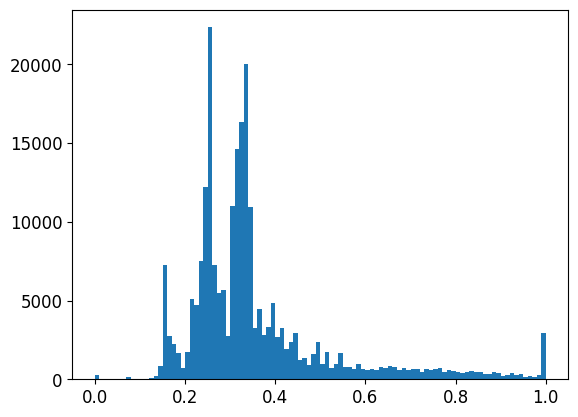

In [45]:
df.endpoint.hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12)

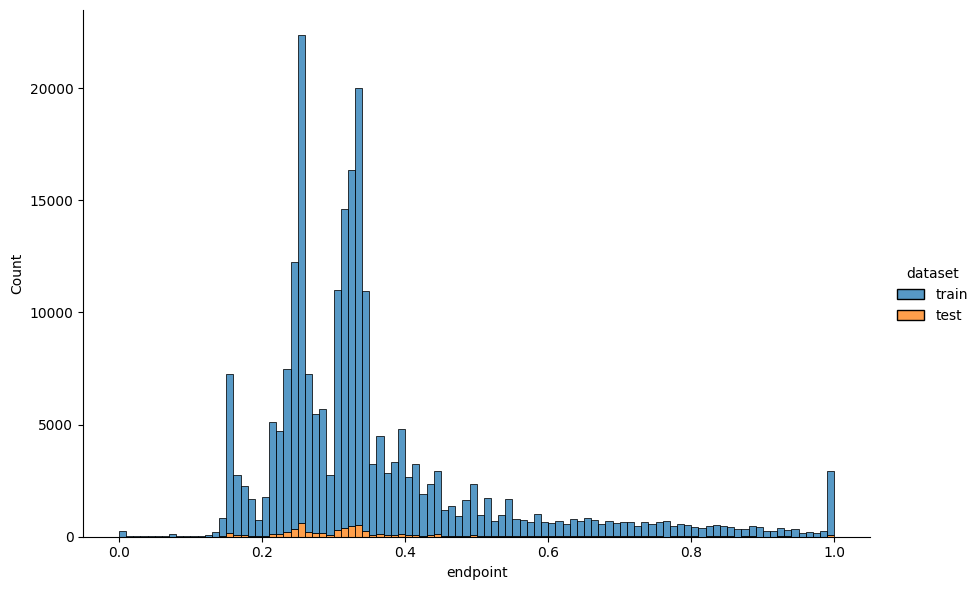

In [46]:
import seaborn as sns

sns.displot(df, x="endpoint",  hue="dataset", kind="hist", 
             height=6, aspect=1.5, bins=100, multiple="stack")




# trian and test set for non CV

In [47]:
df.dataset.value_counts()

dataset
train    229312
test       6369
Name: count, dtype: int64

In [ ]:
df

In [48]:
df[df.dataset=="train"].to_parquet("../data/AzothBio/processed/IC/ec_train.parquet", index=False)
df[df.dataset=="test"].to_parquet("../data/AzothBio/processed/IC/ec_test.parquet", index=False)
